## MeLi Data Challenge 2019

This notebook is part of a curated version of my original solution for the MeLi Data Challenge hosted by [Mercado Libre](https://www.mercadolibre.com/) in 2019

The goal of this first challenge was to create a model that would classify items into categories based solely on the item’s title. 

This title is a free text input from the seller that would become the header of the listings.

<div class="alert alert-block alert-info">
<b>Note</b> <p>At the end of this notebook, 1% of the data is selected to be used in the rest of the series to improve the experience.</p>
    <p>Also, only spanish data is being used in this notebooks for simplicity reasons only</p>
    <p>In the scripted version, 100% of the data is used to improve results</p>
</div>

### 1 - EDA

In this notebook I'm collecting all the EDA that I performed for this competition and insights I obtained from it

### Import libraries

In [38]:
import pandas as pd
import dataframe_image as dfi
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
tqdm.pandas()
import nltk
nltk.download('punkt')
from PIL import Image

[nltk_data] Downloading package punkt to /Users/lbasla002/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

It can be downloaded from here:
- [train](https://meli-data-challenge.s3.amazonaws.com/train.csv.gz)

- [test](https://meli-data-challenge.s3.amazonaws.com/test.csv)

In [4]:
train_data = pd.read_csv('./../data/train.csv.gz', compression='gzip')
test_data = pd.read_csv('./../data/test.csv')

In [72]:
def resize_image(img_path, max_width=1600, max_height=400):
    img = Image.open(img_path)
    w, h = img.size
    if w > max_width:
        new_h = max_width*(h/w)
    if new_h > max_height:
        new_w = max_height*(w/h)
        img = img.resize((int(new_w), int(max_height)), Image.Resampling.LANCZOS)
        print("resized W")
    else:
        img = img.resize((int(max_width), int(new_h)), Image.Resampling.LANCZOS)
        print('resized H')
    img.save(img_path)

### Basic info

In [73]:
train_data.head()

,title,label_quality,language,category
0,Hidrolavadora Lavor One 120 Bar 1700w Bomba A...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS
1,Placa De Sonido - Behringer Umc22,unreliable,spanish,SOUND_CARDS
2,Maquina De Lavar Electrolux 12 Kilos,unreliable,portuguese,WASHING_MACHINES
3,Par Disco De Freio Diant Vent Gol 8v 08/ Frema...,unreliable,portuguese,VEHICLE_BRAKE_DISCS
4,Flashes Led Pestañas Luminoso Falso Pestañas P...,unreliable,spanish,FALSE_EYELASHES


In [74]:
img_path = "./../images/1_sampledata.png"
dfi.export(train_data.head(), img_path, dpi=600)
resize_image(img_path)

objc[76662]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb56488ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x10c0f9568). One of the two will be used. Which one is undefined.
[1230/000357.559596:INFO:headless_shell.cc(623)] Written to file /var/folders/1r/hlm76d9d6r7058jg86msr16r0000gn/T/tmps_b48r9x/temp.png.


resized H


In [75]:
test_data.head()

,id,title,language
0,0,Kit Maternidade Bolsa-mala Baby/bebe Vinho Men...,portuguese
1,1,Trocador De Fraldas Fisher Price Feminino Rosa...,portuguese
2,2,Motor Ventoinha - Fiat Idea / Palio 1.8 - A 04...,portuguese
3,3,Amortecedor Mola Batente D Dir New Civic 14 - ...,portuguese
4,4,Cadeirinha De Carro Bebê Princesa Princess 9 A...,portuguese


In [76]:
img_path = "./../images/2_testdata.png"
dfi.export(test_data.head(), img_path, dpi=600)
resize_image(img_path)

objc[76687]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb56488ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x11252e568). One of the two will be used. Which one is undefined.
[1230/000404.371302:INFO:headless_shell.cc(623)] Written to file /var/folders/1r/hlm76d9d6r7058jg86msr16r0000gn/T/tmpxv825um2/temp.png.


resized W


In [77]:
train_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 4 columns):
 #   Column         Non-Null Count     Dtype 
---  ------         --------------     ----- 
 0   title          20000000 non-null  object
 1   label_quality  20000000 non-null  object
 2   language       20000000 non-null  object
 3   category       20000000 non-null  object
dtypes: object(4)
memory usage: 610.4+ MB


In [78]:
test_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246955 entries, 0 to 246954
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        246955 non-null  int64 
 1   title     246955 non-null  object
 2   language  246955 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.7+ MB


In [79]:
train_data.language.value_counts(normalize=True)

spanish       0.5
portuguese    0.5
Name: language, dtype: float64

In [80]:
test_data.language.value_counts(normalize=True)

spanish       0.506112
portuguese    0.493888
Name: language, dtype: float64

In [81]:
train_data.category.nunique()

1588

We can see that the training data contains 20M rows and it's splitted half for spanish and half for portuguese

The test data, is not a perfect 50/50 split but it's very close to it.

We can also see that there are 1588 different classes to predict and each title has one class

### Categories
In the next few cells we see the count of titles in each categories and a few histograms showing its distribution overall and splitted by language

In [82]:
train_data.category.value_counts(sort=True)

PANTS                                   35973
COFFEE_MAKERS                           35104
BABY_CAR_SEATS                          34163
MUSICAL_KEYBOARDS                       33222
MATTRESSES                              32967
                                        ...  
CONSTRUCTION_LIME_BAGS                    206
COLD_FOOD_AND_DRINK_VENDING_MACHINES      162
PAINTBALL_SMOKE_GRENADES                  154
COMMERCIAL_POPCORN_MACHINES               141
HAMBURGER_FORMERS                         109
Name: category, Length: 1588, dtype: int64

<AxesSubplot:xlabel='category', ylabel='Count'>

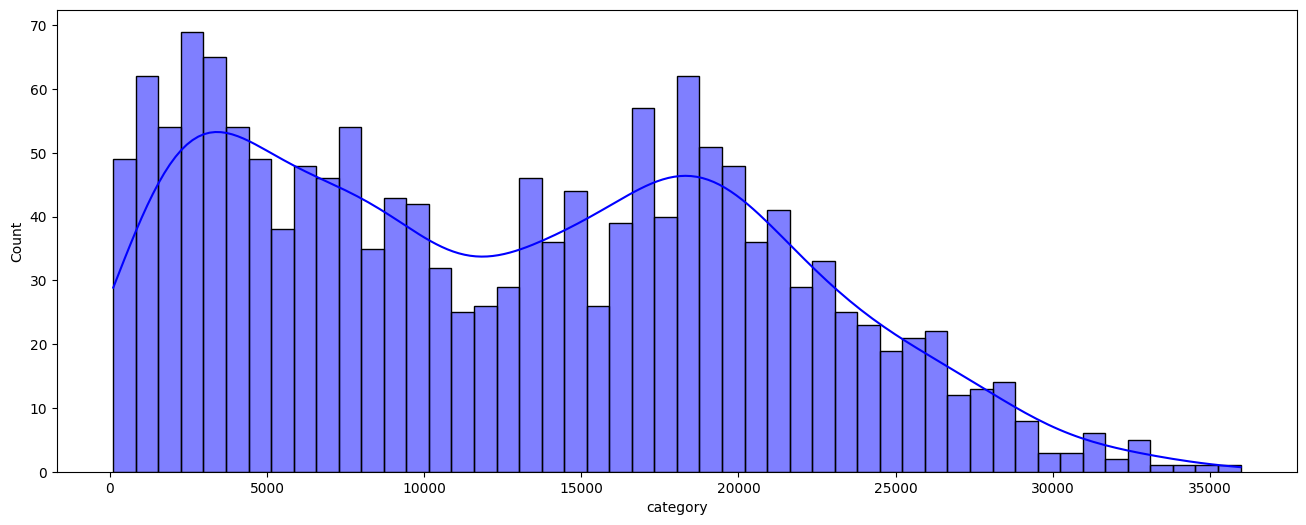

In [83]:
plt.figure(figsize=(16,6), dpi=100)
sns.histplot(train_data.category.value_counts(), color='blue', bins=50, kde=True)

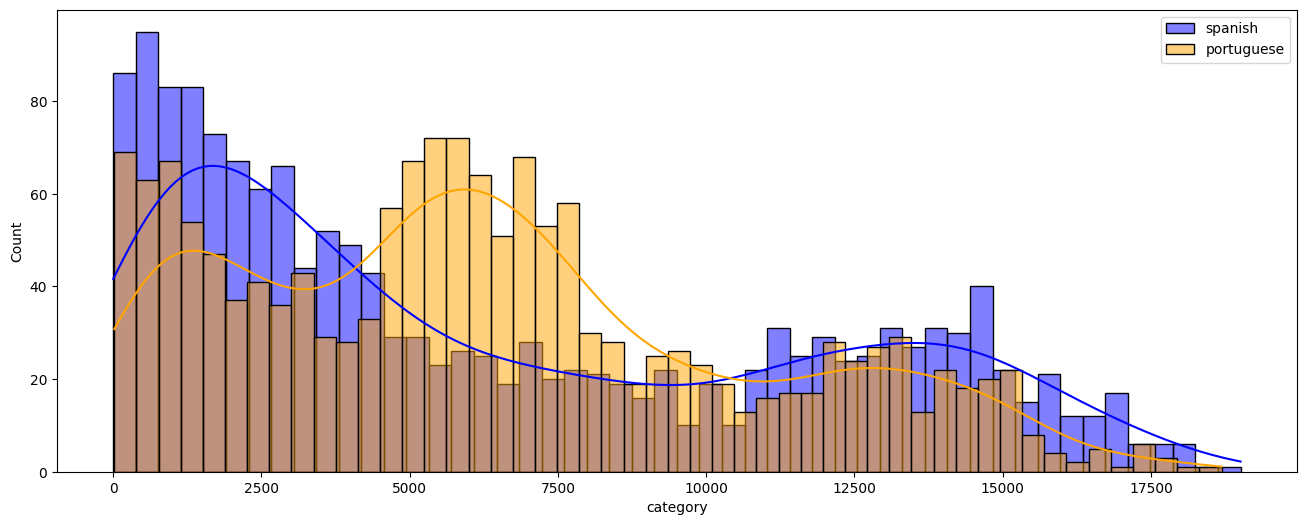

In [99]:
img_path = './../images/3_categoryhistogram.png'
plt.figure(figsize=(16,6), dpi=100)
sns.histplot(train_data[train_data.language == 'spanish'].category.value_counts(), 
             label='spanish', kde=True, color='blue', bins=50)
sns_plot = sns.histplot(train_data[train_data.language == 'portuguese'].category.value_counts(), 
             label='portuguese', kde=True, color='orange', bins=50)
plt.legend()
fig = sns_plot.get_figure()
fig.savefig(img_path,bbox_inches='tight')

In [85]:
train_data[train_data.language == "spanish"].category.value_counts(sort=True)

BOOKS                          19010
ACTION_FIGURES                 18433
MAGAZINES                      18081
FOOTBALL_SHIRTS                17923
DIECAST_VEHICLES               17923
                               ...  
SCALE_RULERS                      49
COMMERCIAL_POPCORN_MACHINES       36
SNACK_HOLDERS                      9
ANTI_STATIC_PLIERS                 5
CARD_PAYMENT_TERMINALS             2
Name: category, Length: 1574, dtype: int64

In [86]:
train_data[train_data.language == "portuguese"].category.value_counts(sort=True)

PANTS                       18689
MEMORY_CARDS                18257
PUREBRED_DOGS               17909
CAR_AV_RECEIVERS            17788
COFFEE_MAKERS               17607
                            ...  
PACKAGING_CONTAINERS           33
MARTIAL_ARTS_FOOT_GUARDS       30
COFFEE_VENDING_MACHINES        29
HAMBURGER_FORMERS              23
FIELD_HOCKEY_STICKS            20
Name: category, Length: 1576, dtype: int64

### Overlap
How many categories are only present in one language

In [87]:
spanish_data = train_data[train_data.language == "spanish"]
portuguese_data = train_data[train_data.language == "portuguese"]

In [88]:
len(portuguese_data[~portuguese_data.category.isin(spanish_data.category.unique())].category.unique())

14

In [89]:
len(spanish_data[~spanish_data.category.isin(portuguese_data.category.unique())].category.unique())

12

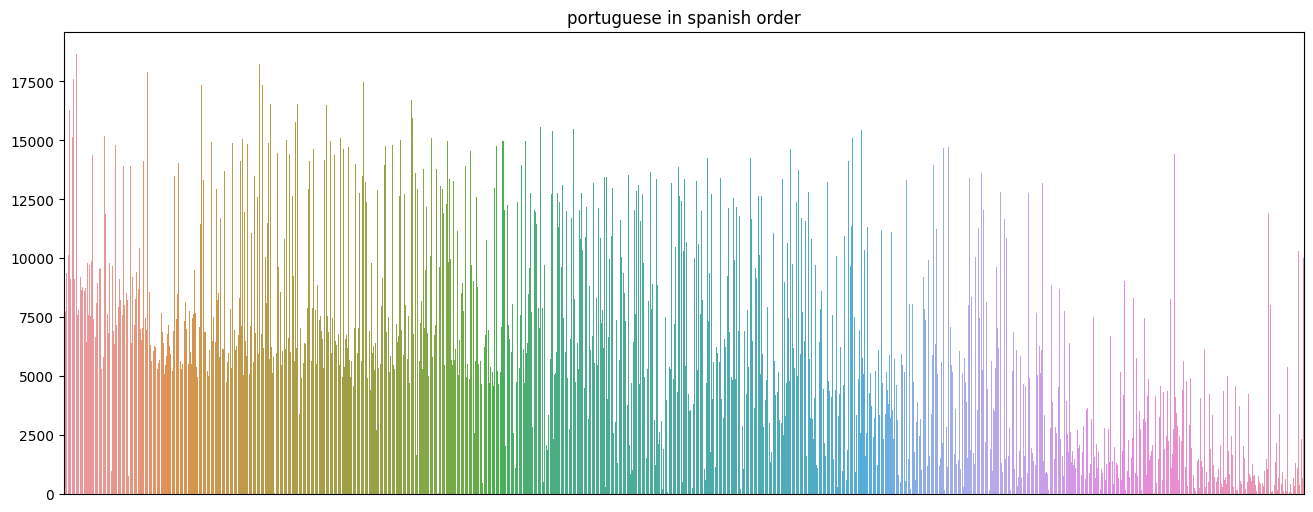

In [100]:
img_path = './../images/4_portspanishorder.png'
plt.figure(figsize=(16,6), dpi=100)

miss_spanish = spanish_data[~spanish_data.category.isin(portuguese_data.category.unique())].category.unique()
port_spa_order = portuguese_data.category.value_counts()[
    spanish_data[~spanish_data.category.isin(miss_spanish)
                ].category.value_counts().index]
ax = sns.barplot(x=port_spa_order.index, y=port_spa_order)
ax.set_title('portuguese in spanish order')
ax.set_xticks([])
ax.set_ylabel('')
fig = ax.get_figure()
fig.savefig(img_path,bbox_inches='tight')

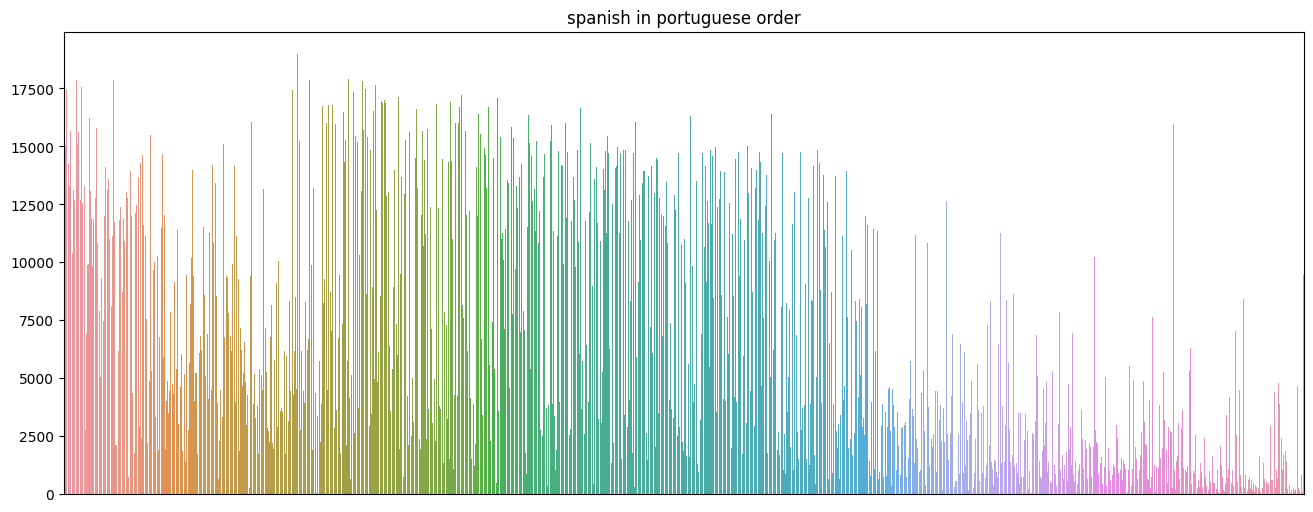

In [101]:
img_path = './../images/5_spanishportorder.png'
plt.figure(figsize=(16,6), dpi=100)

miss_portuguese = portuguese_data[~portuguese_data.category.isin(spanish_data.category.unique())].category.unique()
spa_por_order = spanish_data.category.value_counts()[
    portuguese_data[~portuguese_data.category.isin(miss_portuguese)
                ].category.value_counts().index]
ax = sns.barplot(x=spa_por_order.index, y=spa_por_order)
ax.set_title('spanish in portuguese order')
ax.set_xticks([])
ax.set_ylabel('')
fig = ax.get_figure()
fig.savefig(img_path,bbox_inches='tight')

### Title length

In [92]:
# Calcualte the length of the title in number of chars

train_data['len_title'] = train_data.progress_apply(lambda x: len(x.title), axis=1)

  0%|          | 0/20000000 [00:00<?, ?it/s]

In [93]:
# Calculate the number of words in each title. 
# We use a rough split here to have an initial idea since it's faster than applying word_tokenize

# train_data['tokenized_title'] = train_data.progress_apply(lambda x: word_tokenize(x.title), axis=1)
train_data['tokenized_title'] = [[w for w in s.split(" ") if len(w.strip()) > 0] for s in train_data['title'].values]

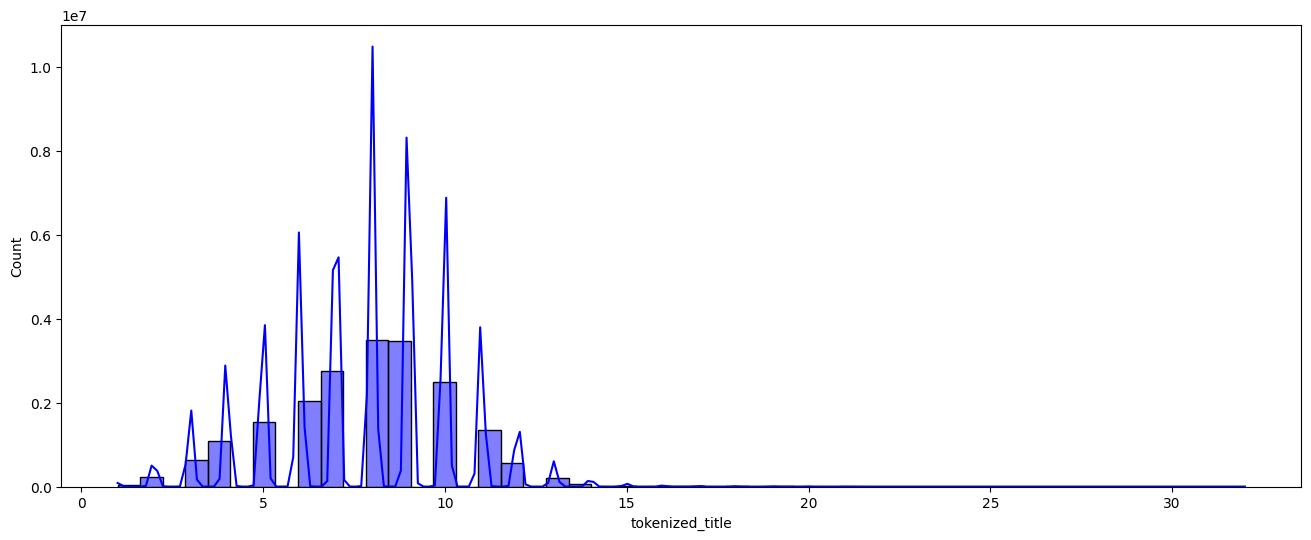

In [102]:
img_path = './../images/7_wordlen.png'
plt.figure(figsize=(16,6), dpi=100)
sns_plot = sns.histplot(train_data['tokenized_title'].map(len), color='blue', bins=50, kde=True)
fig = sns_plot.get_figure()
fig.savefig(img_path,bbox_inches='tight')

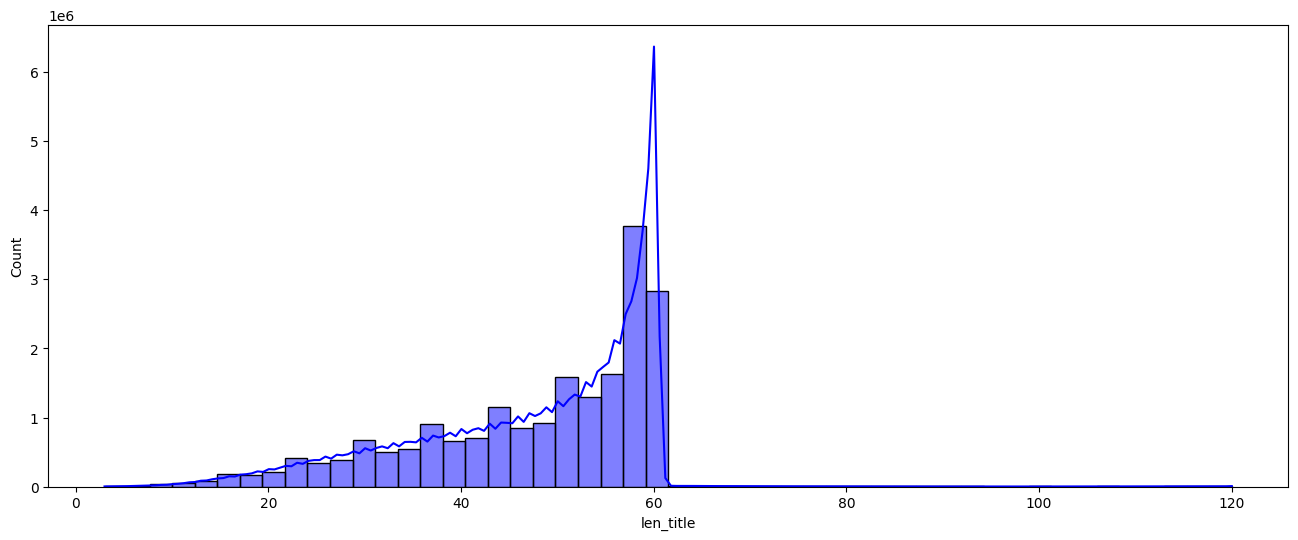

In [103]:
img_path = './../images/6_lentitle.png'
plt.figure(figsize=(16,6), dpi=100)
sns_plot = sns.histplot(train_data['len_title'], color='blue', bins=50, kde=True)
fig = sns_plot.get_figure()
fig.savefig(img_path,bbox_inches='tight')

It seems that there is a 60 chars limit in the titles that under some reasons (or maybe in the past) it was 120. We don't have temporal information about the posts so we'll probably trim the titles to have all of them similar length

We can also see that the mean is somewhere around 8 words with no post going above 35, this initially looks good in terms of how much data we might lose if we trim the inputs

### Label quality

Finally, there's the label quality column.

Based on the hosts, the labels on the data are extracted directly from the users selection and only the ones that are flagged as "reliable" have been reviewd by a company employee to ensure that the category is accurate.

We can find some value for this column while designing the model, but we also know that the test set wasn't reviewed. Hence, if we base the modes too much in this flag we might get worst results.

For my best score, I ignored this column completely while training.

In [96]:
train_data['label_quality'].value_counts()

unreliable    18815755
reliable       1184245
Name: label_quality, dtype: int64

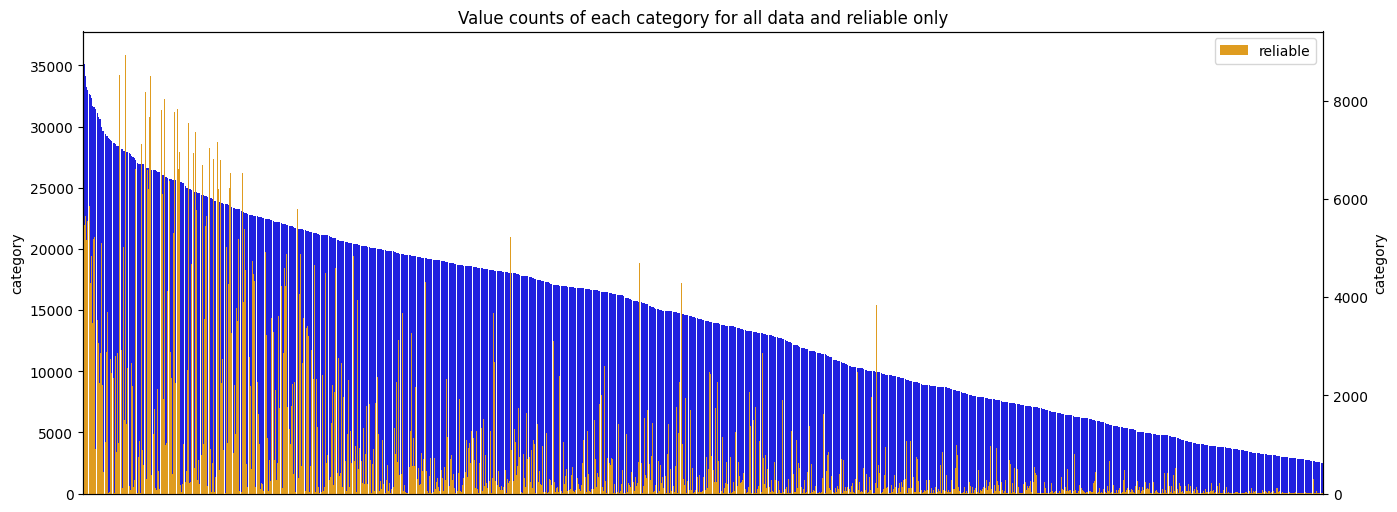

In [97]:
plt.figure(figsize=(16,6), dpi=100)

ax = sns.barplot(x=train_data['category'].value_counts().index, y=train_data['category'].value_counts(), color='blue')
ax.set_xticks([])

ax.set_title('Value counts of each category for all data and reliable only')

ax2 = plt.twinx()
rel_data = train_data[train_data['label_quality'] == 'reliable']['category'].value_counts()
rel_cols = [col for col in train_data['category'].value_counts().index if col in rel_data.index]
ax2 = sns.barplot(x=rel_data[rel_cols].index, y=rel_data[rel_cols], color='orange', ax=ax2, label='reliable')
ax2.set_xticks([])
plt.legend()

### Select 1% of the data

1% of the data (1% of each language) is being extracted to improve experience in the followin notebooks

In [28]:
train_data = pd.read_csv('./../data/train.csv.gz', compression='gzip')

In [29]:
sample_size = int(train_data[train_data.language == 'spanish'].shape[0] / 50)
spanish_data = train_data[train_data.language == 'spanish'].sample(sample_size)

# sample_size = int(train_data[train_data.language == 'portuguese'].shape[0] / 100)
# portuguese_data = train_data[train_data.language == 'portuguese'].sample(sample_size)

# sample_data = pd.concat([spanish_data, portuguese_data])

In [30]:
spanish_data.shape

(200000, 4)

In [31]:
spanish_data.reset_index(inplace=True, drop=True)

In [32]:
spanish_data.to_csv('./../data/sample_train.csv')